# XAI - homework 2

Mateusz Biesiadowski mb406097

# Report

### 1) Train a tree-based ensemble model on the selected dataset
I trained a RandomForestClassifier on a heart-attack-analysis-prediction-dataset

### 2) Select two observations from the dataset and calculate the model's prediction.

I selected two first two samples from the dataset

### 3) Calculate the decomposition of predictions
I used dalex and shap to calculate variable attributions of the previously chosen samples
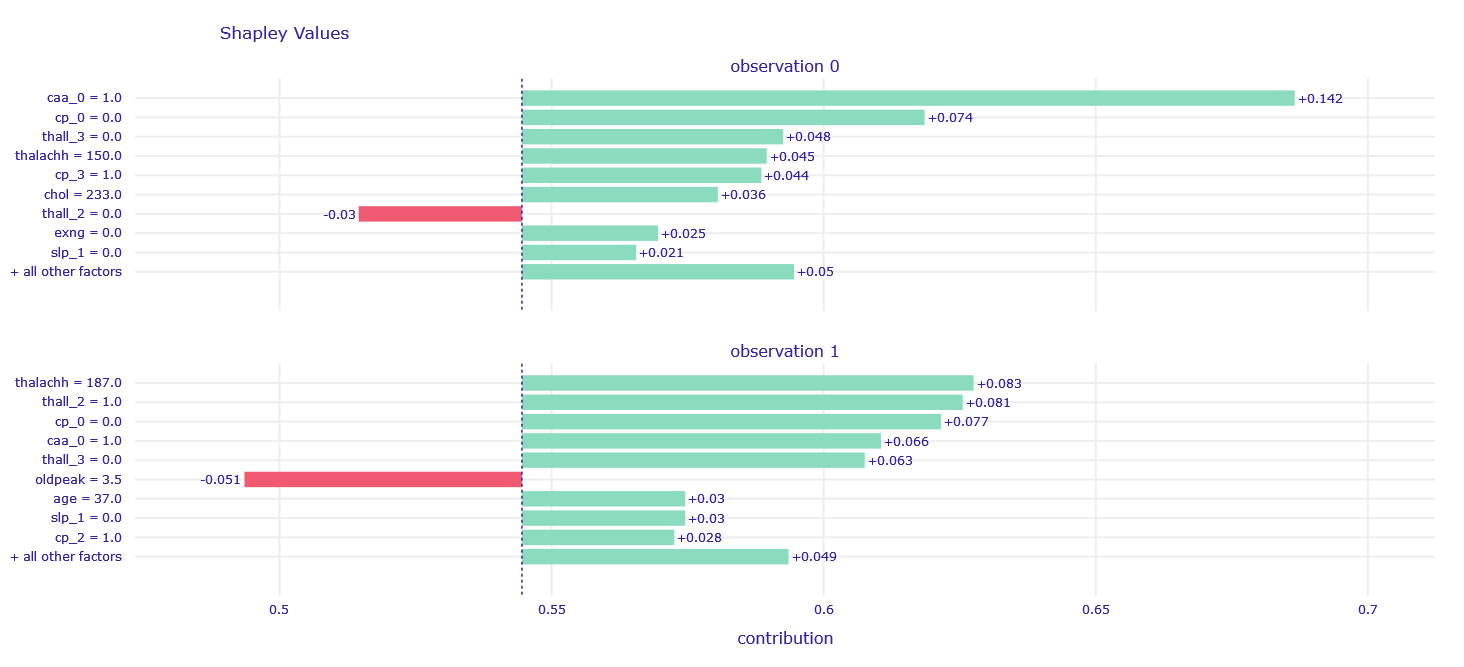

### 4) Find any two observations in the dataset, such that they have different variables of the highest importance

Patients nr 0 and nr 1 have different variables of the highest importance - Number of major vessels = 0 and chest pain type typical angina for patient 0; oldpeak and maximum heart rate achieved for patient 1

---

Patient 0

---


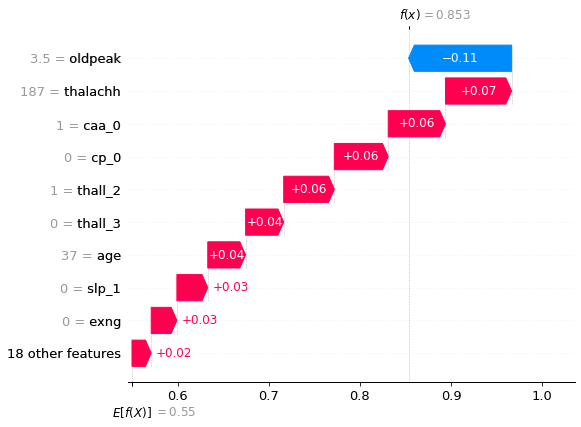

---

Patient 1

---

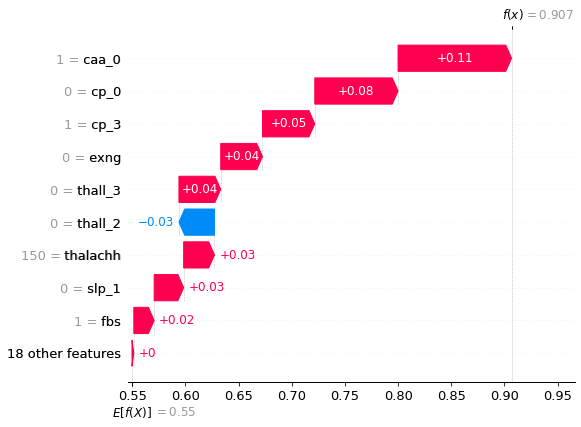

### 5) Select one variable X and find two observations in the dataset such that for one observation, X has a positive attribution, and for the other observation, X has a negative attribution.

Thall=2 has a positive attribution for patient 0 and negative attribution for patient 1.

(plot above)

### 6) Do the results differ across the two packages selected in point (3)?
Attributions have the same sentiment, but differ in values, between Dalex and Shap

### 7) Train another model of any class: neural network, linear model, decision tree etc. and find an observation for which SHAP attributions are different between this model and the one trained in point (1).

I trained DecisionTreeClassifier and attributions are different for oldpeak for 14th patient between random forest classifier and decision tree classifier. 

---
RandomForest
---
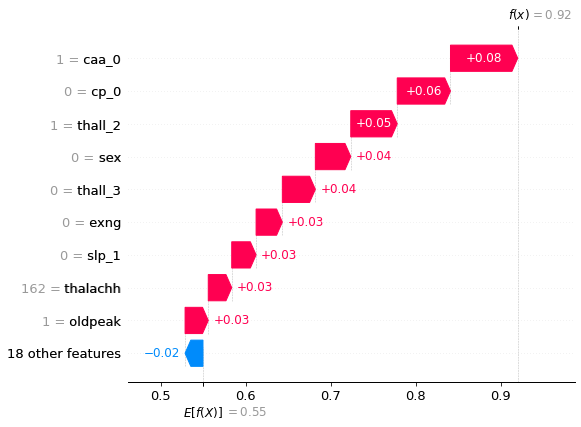

---
DecisionTree
---

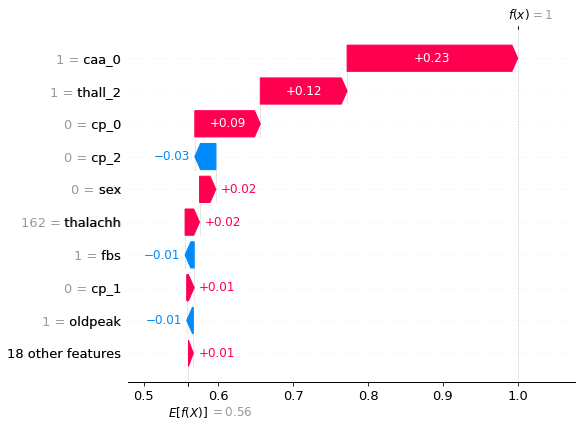

# Appendix

## Imports

In [1]:
!pip install dalex 1> /dev/null
!pip install shap 1> /dev/null

In [21]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import shap
import dalex as dx

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
#@title Set Credentials

kaggle_username = '' #@param {type:"string"}
kaggle_api_key = '' #@param {type:"string"}

try:
    import kaggle
except OSError:
    with open("/root/.kaggle/kaggle.json", "w+") as f:
        f.write('{"username":"' + kaggle_username + '","key":"' + kaggle_api_key + '"}')

os.system("chmod 600 /root/.kaggle/kaggle.json")

0

## Data

### Download dataset

In [4]:
# import kaggle

!kaggle datasets download -d rashikrahmanpritom/heart-attack-analysis-prediction-dataset
!unzip /content/heart-attack-analysis-prediction-dataset.zip

heart-attack-analysis-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/heart-attack-analysis-prediction-dataset.zip
replace heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Get data

In [5]:
df = pd.read_csv("/content/heart.csv")

#Preprocessing

### Config

In [6]:
CATEGORICAL_COLUMNS = ['cp', 'restecg', 'slp', 'caa', 'thall']
RANDOM_STATE = 2137
TEST_SIZE = 0.33

### One hot encoding

In [7]:
for col in CATEGORICAL_COLUMNS:
    one_hot = pd.get_dummies(df[col])
    one_hot = one_hot.add_prefix(col + "_")
    df = df.drop(col, axis=1)
    df = pd.concat([df, one_hot], axis=1)

In [8]:
df.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,output,cp_0,...,slp_2,caa_0,caa_1,caa_2,caa_3,caa_4,thall_0,thall_1,thall_2,thall_3
0,63,1,145,233,1,150,0,2.3,1,0,...,0,1,0,0,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,1,0,...,0,1,0,0,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,1,0,...,1,1,0,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,1,0,...,1,1,0,0,0,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,1,1,...,1,1,0,0,0,0,0,0,1,0


### Split data

In [9]:
X, y = df.drop('output', axis=1), df.output

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Model

In [10]:
model_rfc = RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE)

In [11]:
model_rfc.fit(X, y)

RandomForestClassifier(n_estimators=150, random_state=2137)

In [12]:
print(model_rfc.predict(X.iloc[0:2]))

print(model_rfc.predict_proba(X.iloc[0:2]))

[1 1]
[[0.09333333 0.90666667]
 [0.14666667 0.85333333]]


## Explanations

### Dalex explanation

In [13]:
model = model_rfc

my_model_function = lambda m, d: m.predict(d)

explainer = dx.Explainer(model, X, y, predict_function=my_model_function, label="RFC")

Preparation of a new explainer is initiated

  -> data              : 303 rows 27 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RFC
  -> predict function  : <function <lambda> at 0x7f58ce4820e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.545, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = 0.0, mean = 0.0, max = 0.0
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [17]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
RFC,1.0,1.0,1.0,1.0,1.0


In [18]:
explainer.predict(X[0:2])

array([1, 1])

In [20]:
shap_attributions = [explainer.predict_parts(X.iloc[[i]], type="shap", label=f'observation {i}') for i in range(2)]

In [14]:
shap_attributions[0].plot(shap_attributions[1::])

### Shap explanation

In [15]:
explainer_shap_tree = shap.explainers.Tree(model_rfc, data=X, model_output='probability', random_state=RANDOM_STATE)
shap_values_tree = explainer_shap_tree(X)[:,:,1]

Explanation for patient nr 0 heart attack probability prediction


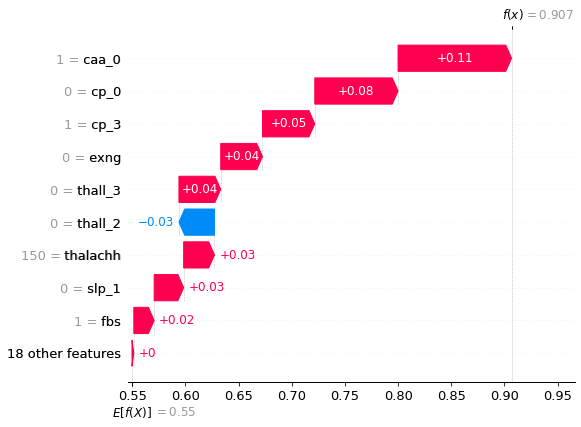

Explanation for patient nr 1 heart attack probability prediction


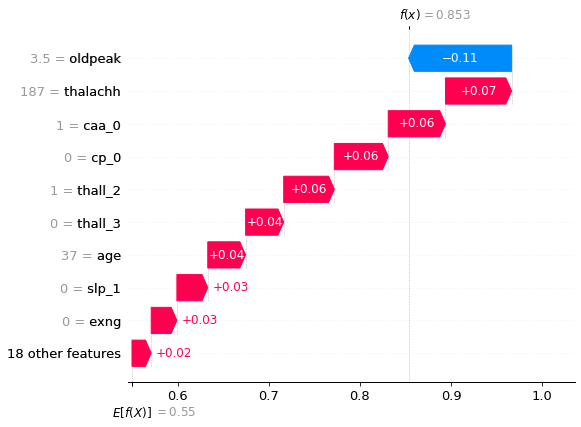

In [16]:
for i in range(2):
  print(f"Explanation for patient nr {i} heart attack probability prediction")
  shap.plots.waterfall(shap_values_tree[i])

## Compare RandomForest to DecisionTree

In [22]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [24]:
model_dt.fit(X,y)

DecisionTreeClassifier(random_state=2137)

### Explain predictions with Shap

In [25]:
explainer_shap_tree_2 = shap.explainers.Tree(model_dt, data=X, model_output='probability', random_state=RANDOM_STATE)
shap_values_tree_2 = explainer_shap_tree_2(X)[:,:,1]

### Compare explanations

##########  Patient 14  ##########
----------  RandomForest


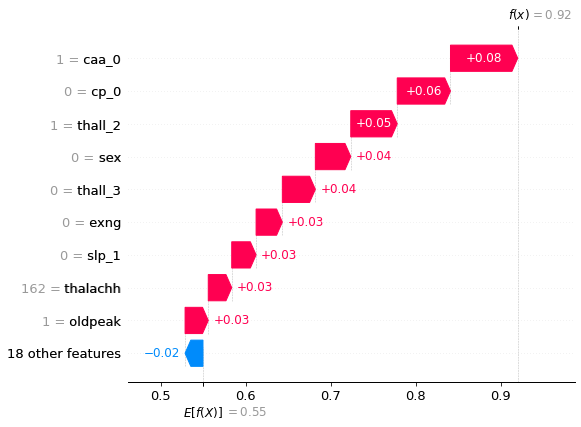

----------  DecisionTree


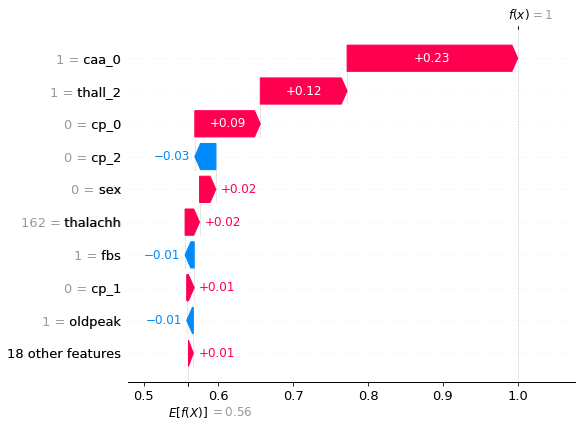

In [33]:
PATIENT_IDX = 14
NO_EXPLANATIONS = 1
rf_shap = explainer_shap_tree(X)[PATIENT_IDX:PATIENT_IDX + NO_EXPLANATIONS][:,:,1]
df_shap = explainer_shap_tree_2(X)[PATIENT_IDX:PATIENT_IDX + NO_EXPLANATIONS][:,:,1]

for i in range(NO_EXPLANATIONS):
    print(f"{10 * '#'}  Patient {PATIENT_IDX + i}  {10 * '#'}")
    print(f"{10 * '-'}  RandomForest")
    shap.plots.waterfall(rf_shap[i])
    print(f"{10 * '-'}  DecisionTree")
    shap.plots.waterfall(df_shap[i])

In [38]:
!jupyter nbconvert --to=html xai_homework2.ipynb


[NbConvertApp] Converting notebook xai_homework2.ipynb to html
[NbConvertApp] Writing 716648 bytes to xai_homework2.html
